#  ATOC5860 Application Lab #2 - AR1_Nstar
##### Originally coded by Prof. Kay (CU) and Elizabeth Maroon (CU, now U.Wisc) with input from Hannah Zanowski (CU, now U.Wisc)
##### last updated February 10, 2023

### LEARNING GOALS:
1) Calculate the autocorrelation at a range of lags using two methods available in python (np.correlate, dot products)
2) Estimate the effective sample size (N*) using the lag-1 autocorrelation
3) Evaluate the influence of changing the sampling frequency and the specified weather variable on the memory/redness of the data as quantified by the autocorrelation and N*.


### DATA and UNDERLYING SCIENCE MOTIVATION:  
In this notebook, you will analyze the memory (red noise) in weather observations from Fort Colins, Colorado at Christman Field.  The observations are from one year, but are sampled hourly. The default settings for the notebook analyze the air temperature in degrees F sampled once daily (every midnight).  But other standard weather variables and sampling frequencies can also be easily analyzed.  The file containing the data is called **christman_2016.csv** and it is a comma-delimited text file.


### Non-exhaustive Questions to guide your analysis:  

1) Start with the default settings in the code.  In other words – Read in the data and find the air temperature every 24 hours (every midnight) over the entire year.  Calculate the lag-1 autocorrelation using np.correlate and the direct method using dot products.  Compare the python syntax for calculating the autocorrelation with the formulas in Barnes.  Equation numbers are provided to refer you back to the Barnes Notes. What is the lag-1 autocorrelation?  

2) Calculate the autocorrelation at a range of lags using np.correlate and the direct method using dot products.  Compare the python syntax for calculating the autocorrelation with the formulas in Barnes.  Equation numbers are provided to refer you back to the Barnes Notes. How does the autocorrelation change as you vary the lag from -40 days to +40 days?

3) Calculate the effective sample size (N*) and compare it to your original sample size (N). Equation numbers are provided to refer you back to the Barnes Notes.  How much memory is there in temperature sampled every midnight?

4) Now you are ready to tinker … i.e., make minor adjustments to the code with the parameters set in the code to see how your results change.  Suggestion: Make a copy of the notebook for your tinkering so that you can refer back to your original answers and the unmodified original code. For example: Repeat steps 1-3) above with a different variable (e.g., relative humidity (RH), wind speed (wind_mph)).  Repeat steps 1-3) above with a different temporal sampling frequency (e.g., every 12 hours, every 6 hours, every 4 days).  How do you answers change?  

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xarray
import pandas as pd   ##pandas reads in .csv.
from scipy import stats
import seaborn as sns  ### seaborn just makes things pretty -- no new typing
sns.set_style('whitegrid')  ###  change away from grey grid (seaborn default) to white grid

In [2]:
## Read in the data
filename = 'christman_2016.csv'
data=pd.read_csv(filename,sep=',')
data.head()

,day,hour,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2,Prec_inches
0,42370,0.000000,7.0,72.2,-0.1,1.2,234,3.9,224,851.30,0.0,0.0
1,42370,0.041667,5.4,74.3,-1.0,3.4,299,7.1,302,850.82,0.0,0.0
2,42370,0.083333,6.4,73.8,-0.2,2.8,200,7.0,301,849.83,0.0,0.0
3,42370,0.125000,3.0,73.5,-3.6,2.9,309,6.1,349,850.69,0.0,0.0
4,42370,0.166667,3.7,76.9,-1.9,3.1,346,5.3,255,848.24,0.0,0.0


minimum data value:  -14.3
maximum data value:  80.1


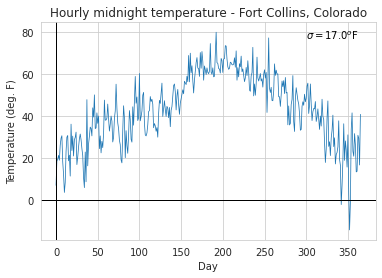

In [15]:
## Plot midnight temperature data for Fort Collins, Colorado
X=data['temp_F']
X_daily=X[::24] ## sample the hourly data every 24 hours
print('minimum data value: ',X_daily.min())
print('maximum data value: ',X_daily.max())
xindex = (np.arange(0,np.size(X),1))/24.
xindex_daily=xindex[::24] ## sample the index every 24 hours
plt.plot(xindex_daily, X_daily, linewidth = 0.75)
v = np.std(X_daily)
plt.text(0.95, 0.925,'$\sigma = $' + str(np.round(v)) + '$^o$F', ha='right', transform=plt.gca().transAxes, color = 'k')
ymin, ymax = plt.ylim(); #get the boundary values of the default plt.plot()
xmin, xmax = plt.xlim();
lines = plt.plot((xmin, xmax),(0, 0),(0, 0),(ymin, ymax));
plt.setp(lines,color='black', linewidth=1);
plt.ylim((ymin, ymax));
plt.xlim((xmin, xmax));
plt.ylabel('Temperature (deg. F)');
plt.xlabel('Day');
plt.title('Hourly midnight temperature - Fort Collins, Colorado');

In [16]:
#Find the lag-one autocorrelation (AR1)
tseries=X_daily
sigma=np.std(tseries)  ## calculate the standard deviation
mean=np.mean(tseries)  ## calculate the mean
n=len(tseries)         ## calculate the length of the timeseries
lag=1                  ## warning: you cannot change this to be a negative lag. 
                       ## this cell does not work for negative lags - Can you see why?

## remove the mean
tseries1=tseries-mean

##Create two timeseries of the data at t=t1 and t=t2
t1_m=tseries1.iloc[0:-1*lag]
t2_m=tseries1.iloc[lag:]
#print(t1_m.shape)
#print(t2_m.shape)

#Method #1
#Calculate the autocorrelation using numpy correlate lagN
lagNauto_np=np.correlate(t1_m,t2_m,mode='valid')/(n-lag)/(sigma**2)
print('lag',lag,'autocorrelation np.correlate:',round(lagNauto_np[0],3))

#Method #2 - direct calculation
#Calculate the autocorrelation using numpy dot
## (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.dot.html)
lagNauto=np.dot(t1_m,t2_m)/(n-lag)/sigma**2 ## Barnes Chapter 2 Eq. 68 divided by the variance
print('lag',lag,'autocorrelation direct calc:',round(lagNauto,3))

if lag==1: alpha=lagNauto

lag 1 autocorrelation np.correlate: 0.846
lag 1 autocorrelation direct calc: 0.846


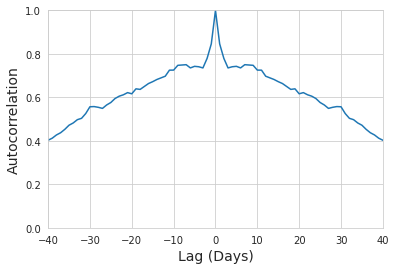

In [17]:
# Calculate the autocorrelation at all lags and plot it
# Is it symmetric about 0 lag?  Should it be? (hint: the answer is yes)
# Ziqi: so the autocorrelations at lag=40 and lag=-40 equal
tseries1=tseries-mean
half=int(len(tseries)/2)
lags=np.arange(-1*half,half,1.)
#print(len(tseries1))
#print(len(lags))
#print(len(np.correlate(tseries1,tseries1,mode='same')))
autocorrelation_function=np.correlate(tseries1,tseries1,mode='same')/((n-np.abs(lags))*sigma**2)  ##Eq. 67 divided by variance
plt.plot(range(-1*half,half),autocorrelation_function)
plt.xlim([-40,40]);
plt.ylim([0.0,1.0]);
plt.xlabel('Lag (Days)',fontsize=14);
plt.ylabel('Autocorrelation',fontsize=14);

In [18]:
## Calculate the effective sample size (N*) for this data 
## Compare your estimate of the number of independent samples (N*) with the number of samples 
## in your original data (N)
N=len(tseries)
print('# samples, N: ',N)
print('lag-1 autocorrelation: ',round(alpha,2))
print('#independent samples, N*: ',round((1-np.abs(alpha))/(1+np.abs(alpha))*N,0)) ## Chapter 2 Barnes Eq. 88
## Note that the value of the autocorrelation used in Eq. 88 should be the absolute value otherwise
## if alpha is negative you end up with more independent samples than original samples

# samples, N:  366
lag-1 autocorrelation:  0.85
#independent samples, N*:  31.0


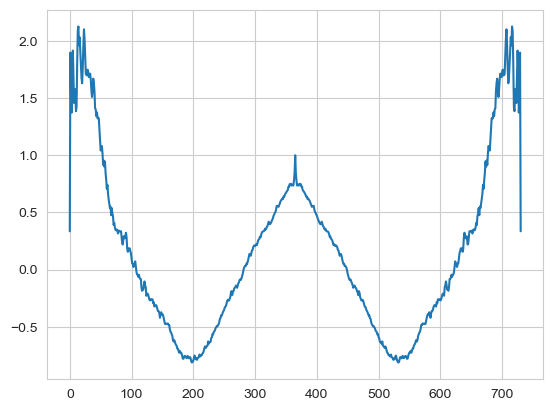

In [18]:
#### EXTRA

## Unsolved mystery of ATOC5860 -- If you want to plot the full autocorrrelation (i.e., vs. all lags)
## You end up with values greater than 1.  But the autocorrelation should be between -1 and 1 (??)

lags_full=np.arange(-n+1,n);
foo=np.correlate(tseries1,tseries1,mode='full')/((n-np.abs(lags_full))*sigma**2);
plt.plot(foo);

## Potential solution??
## Autocorrelation maybe needs to use variance from only the part of the data that are being used?
## Look at Wilks page 58.

#Ziqi: When a very large (compared to N) lag is used, there will be only limited data to work with. According to Wilks[2011], 
#lagged correlations for roughly k>N/2 or k>N/3 are rarely computed.

## Notes

1. Other variables: the lag-1 autocorrelation for midinight wind speed is basically around zero, and the lag-1 autocorrelation for midinight relative humidity is about 0.3, smaller than that of midnight air temperature. Among these three variables, midnight temperature has the largest memory

2. Other temporal sampling frequency (still using air temperature): the lag-1 autocorrelation for air temperature at lag=6hrs, 12hrs, 24hrs, and 4days are 0.762, 0.593, 0.846, and 0.754. I guess the the largest autocorrelation for lag=24hrs is due to the daily cycle of air temperature. Within a daily cycle, lag=12hrs has a lower autocorrelation compared to lag=6hrs

3. Lagged correlations for roughly k>N/2 or k>N/3 are rarely computed, since if a too large (compared to N) lag is used, there will not be enough data left to work with. 